In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, ConcatDataset


In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [ ]:
def driver_dataframe(df, path_order, driver):
    """
    Extracts and processes the DataFrame for a specific driver and path order.

    Parameters:
    df (DataFrame): The original DataFrame.
    path_order (int): The path order identifier.
    driver (str): The driver class identifier.

    Returns:
    DataFrame: Processed DataFrame for the specified driver and path order.
    """
    driver_df = df[df['PathOrder'] == path_order]
    driver_df = driver_df[driver_df['Class'] == driver]
    driver_df = driver_df.sort_values(by='Time(s)')
    driver_df.drop(columns=['Class', 'PathOrder'], inplace=True)
    driver_df = driver_df.groupby('Time(s)').mean()
    driver_df['Time(s)'] = driver_df.index
    return driver_df

In [ ]:
def split_dataset(df, train_ratio=0.8, random_seed=123):
    """
    Splits the dataset into training and testing sets based on driver and path order.

    Parameters:
    df (DataFrame): The original DataFrame.
    train_ratio (float): Ratio of the dataset to be used for training. Default is 0.8.
    random_seed (int): Seed for random number generator. Default is 123.

    Returns:
    DataFrame: Training set.
    DataFrame: Testing set.
    """

    # set a random seed
    np.random.seed(random_seed)

    # create a copy of dataframe
    df_copy = df.copy()

    # Lists to hold individual DataFrames
    df_train = []
    df_test = []

    # Nested loops to process each path and driver
    for path in df_copy['PathOrder'].unique():
        for driver in df_copy['Class'].unique():
            driver_df = driver_dataframe(df_copy, path, driver)
            driver_df['PathOrder'] = path  # Add PathOrder
            driver_df['Class'] = driver    # Add Class

            # Calculate the index to split the data
            split_index = int(train_ratio * len(driver_df))

            # Split the data
            df_train_split = driver_df.iloc[:split_index]
            df_test_split = driver_df.iloc[split_index:]

            # Append the data to df_train and df_test lists
            df_train.append(df_train_split)
            df_test.append(df_test_split)

    # Concatenate the DataFrames
    df_train = pd.concat(df_train, ignore_index=True)
    df_test = pd.concat(df_test, ignore_index=True)

    return df_train, df_test

In [ ]:
selected_features = ['Engine_soacking_time', 'Long_Term_Fuel_Trim_Bank1', 'Engine_coolant_temperature.1',
 'Torque_of_friction', 'Activation_of_Air_compressor', 'Intake_air_pressure', 'PathOrder', 'Accelerator_Pedal_value',
 'Master_cylinder_pressure', 'Vehicle_speed','Engine_coolant_temperature', 'Maximum_indicated_engine_torque',
 'Throttle_position_signal', 'Current_Gear', 'Calculated_LOAD_value', 'Engine_torque_after_correction',
 'Engine_torque', 'Class', 'Time(s)']

In [ ]:
data = pd.read_csv("/content/drive/My Drive/graduation/Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv")

In [ ]:
selected_df = data[selected_features]

In [ ]:
selected_df.head()

,Engine_soacking_time,Long_Term_Fuel_Trim_Bank1,Engine_coolant_temperature.1,Torque_of_friction,Activation_of_Air_compressor,Intake_air_pressure,PathOrder,Accelerator_Pedal_value,Master_cylinder_pressure,Vehicle_speed,Engine_coolant_temperature,Maximum_indicated_engine_torque,Throttle_position_signal,Current_Gear,Calculated_LOAD_value,Engine_torque_after_correction,Engine_torque,Class,Time(s)
0,3,-0.8,87,9.0,0,33,1,0.0,325.5,0,95,58.2,5.2,0,23.9,5.5,5.5,A,1
1,3,-0.8,87,7.8,0,40,1,0.0,0.9,0,95,53.9,6.1,0,30.6,7.0,7.0,A,2
2,3,-0.8,87,7.4,0,41,1,0.0,0.9,0,95,53.1,5.2,0,31.8,7.0,7.0,A,3
3,3,-0.8,87,6.6,0,38,1,0.0,0.9,0,95,53.1,4.7,0,29.0,7.0,7.0,A,4
4,3,-0.8,87,11.3,1,40,1,0.0,0.9,0,95,53.5,5.7,0,30.2,8.2,8.2,A,5


In [ ]:
# df_train, df_test = split_dataset(selected_df, 0.8)

In [ ]:

def driver_dataframe_using_window_size(df, path_order, driver, window_size=60):
    """
    Extracts and processes the DataFrame for a specific driver and path order,
    and calculates rolling statistics with the specified window size.

    Parameters:
    df (DataFrame): The original DataFrame.
    path_order (int): The path order identifier.
    driver (str): The driver class identifier.
    window_size (int): The size of the rolling window.

    Returns:
    DataFrame: Processed DataFrame for the specified driver and path order with
               rolling statistics concatenated to the original features.
    """

    # Filter the DataFrame for the specific driver and path order
    driver_df = df[df['PathOrder'] == path_order]
    driver_df = driver_df[driver_df['Class'] == driver]


    # Drop the 'Class' and 'PathOrder' columns
    time = driver_df['Time(s)']
    driver_df.drop(columns=['Class', 'PathOrder', 'Time(s)'], inplace=True)


    # Calculate rolling statistics
    rolling_mean = driver_df.rolling(window=window_size).mean().add_suffix('_mean')
    rolling_median = driver_df.rolling(window=window_size).median().add_suffix('_median')
    rolling_std = driver_df.rolling(window=window_size).std().add_suffix('_std')
#     rolling_var = driver_df.rolling(window=window_size).var().add_suffix('_var')
#     rolling_min = driver_df.rolling(window=window_size).min().add_suffix('_min')
#     rolling_max = driver_df.rolling(window=window_size).max().add_suffix('_max')

    # Concatenate the original features with the rolling statistics
    # , rolling_var, rolling_min, rolling_max
    driver_df = pd.concat([rolling_mean, rolling_median, rolling_std], axis=1)
    driver_df['Time(s)'] = time
    # Drop the first 'window_size' rows to make the concatenation match
    driver_df = driver_df.iloc[window_size-1:]

    return driver_df


In [ ]:
def prepare_all_drivers(df, random_seed=123):
    """
    Prepares the dataset by processing each driver's data and calculating rolling statistics for each feature.

    Parameters:
    df (DataFrame): The original DataFrame.
    random_seed (int): The seed for the random number generator (default is 123).

    Returns:
    DataFrame: Processed DataFrame with rolling statistics and necessary columns for all drivers.
    """

    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Create a copy of the original DataFrame to ensure the original data is not altered
    df_copy = df.copy()

    # List to hold individual DataFrames for each driver and path
    df_temp = []

    # Nested loops to process each path and driver
    for path in df_copy['PathOrder'].unique():
        for driver in df_copy['Class'].unique():
            # Process the DataFrame for the specific driver and path using window size
            driver_df = driver_dataframe_using_window_size(df_copy, path, driver)
            driver_df['PathOrder'] = path  # Add PathOrder column
            driver_df['Class'] = driver    # Add Class column

            # Append the processed DataFrame to the list
            df_temp.append(driver_df)

    # Concatenate all individual DataFrames into a single DataFrame
    all_drivers = pd.concat(df_temp, ignore_index=True)

    return all_drivers

In [ ]:
alldata = prepare_all_drivers(selected_df)

In [ ]:
alldata.shape

(93200, 51)

In [ ]:
alldata.head()

,Engine_soacking_time_mean,Long_Term_Fuel_Trim_Bank1_mean,Engine_coolant_temperature.1_mean,Torque_of_friction_mean,Activation_of_Air_compressor_mean,Intake_air_pressure_mean,Accelerator_Pedal_value_mean,Master_cylinder_pressure_mean,Vehicle_speed_mean,Engine_coolant_temperature_mean,Maximum_indicated_engine_torque_mean,Throttle_position_signal_mean,Current_Gear_mean,Calculated_LOAD_value_mean,Engine_torque_after_correction_mean,Engine_torque_mean,Engine_soacking_time_median,Long_Term_Fuel_Trim_Bank1_median,Engine_coolant_temperature.1_median,Torque_of_friction_median,Activation_of_Air_compressor_median,Intake_air_pressure_median,Accelerator_Pedal_value_median,Master_cylinder_pressure_median,Vehicle_speed_median,Engine_coolant_temperature_median,Maximum_indicated_engine_torque_median,Throttle_position_signal_median,Current_Gear_median,Calculated_LOAD_value_median,Engine_torque_after_correction_median,Engine_torque_median,Engine_soacking_time_std,Long_Term_Fuel_Trim_Bank1_std,Engine_coolant_temperature.1_std,Torque_of_friction_std,Activation_of_Air_compressor_std,Intake_air_pressure_std,Accelerator_Pedal_value_std,Master_cylinder_pressure_std,Vehicle_speed_std,Engine_coolant_temperature_std,Maximum_indicated_engine_torque_std,Throttle_position_signal_std,Current_Gear_std,Calculated_LOAD_value_std,Engine_torque_after_correction_std,Engine_torque_std,Time(s),PathOrder,Class
0,3.0,-0.200000,86.266667,18.671667,0.933333,59.400000,1.921667,10.826667,6.066667,89.950000,59.216667,8.570000,5.05,48.433333,23.788333,23.788333,3.0,0.0,86.0,19.1,1.0,64.0,0.0,1.1,3.0,90.0,54.3,8.00,2.0,52.55,25.6,25.8,0.0,0.349334,0.445948,3.337618,0.251549,12.296065,4.200811,42.745042,7.094679,3.538768,7.554058,2.707072,5.958685,11.774271,8.202317,8.207274,60,1,A
1,3.0,-0.186667,86.266667,18.835000,0.950000,59.616667,1.921667,5.435000,6.383333,89.783333,59.275000,8.608333,5.10,48.623333,23.990000,23.990000,3.0,0.0,86.0,19.1,1.0,64.0,0.0,1.1,3.5,90.0,54.3,8.00,2.0,52.55,25.6,25.8,0.0,0.341217,0.445948,3.086648,0.219784,11.932141,4.200811,10.981939,7.241808,3.532376,7.559585,2.674632,5.928100,11.459440,7.887766,7.892921,61,1,A
2,3.0,-0.173333,86.266667,19.018333,0.966667,59.833333,1.986667,5.438333,6.683333,89.616667,59.418333,8.663333,5.15,48.813333,24.290000,24.290000,3.0,0.0,86.0,19.1,1.0,64.0,0.0,1.1,4.0,90.0,54.3,8.00,2.0,52.55,25.6,25.8,0.0,0.332360,0.445948,2.725678,0.181020,11.685376,4.200745,10.980570,7.344989,3.517952,7.537443,2.656043,5.896925,11.248103,7.566377,7.571752,62,1,A
3,3.0,-0.160000,86.266667,19.188333,0.983333,60.450000,2.266667,5.441667,6.983333,89.450000,59.666667,8.858333,5.20,49.401667,24.870000,24.870000,3.0,0.0,86.0,19.1,1.0,64.5,0.0,1.1,4.0,90.0,54.5,8.25,2.0,53.50,25.8,26.0,0.0,0.322700,0.445948,2.268509,0.129099,11.650889,4.606394,10.979199,7.434440,3.495396,7.571124,2.821785,5.865151,11.266306,7.552333,7.557717,63,1,A
4,3.0,-0.146667,86.266667,19.365000,1.000000,61.416667,2.625000,5.445000,7.300000,89.283333,60.011667,9.758333,5.25,50.408333,25.606667,25.606667,3.0,0.0,86.0,19.1,1.0,65.0,0.0,1.1,4.0,90.0,55.5,8.50,2.0,54.10,25.8,26.2,0.0,0.312164,0.445948,1.579726,0.000000,12.151992,5.222170,10.977827,7.535903,3.464550,7.736642,6.996471,5.832768,12.081423,7.926139,7.931270,64,1,A


### Data Preprocessing

In [ ]:
deriver_d_path1 = alldata[(alldata['Class']=="D") & (alldata['PathOrder']==1) ]
deriver_d_path2 = alldata[(alldata['Class']=="D") & (alldata['PathOrder']==2) ]

In [ ]:
deriver_d_path1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
deriver_d_path2.drop(columns=['Time(s)','PathOrder', 'Class'], inplace=True)

In [ ]:
# Calculate the test size
test_size = 0.2
test_len1 = int(len(deriver_d_path1) * test_size)
test_len2 = int(len(deriver_d_path2) * test_size)

# Split deriver_d_path1: take the test set from the end
train1 = deriver_d_path1.iloc[:-test_len1]
test1 = deriver_d_path1.iloc[-test_len1:]

# Split deriver_d_path2: take the test set from the start
train2 = deriver_d_path2.iloc[test_len2:]
test2 = deriver_d_path2.iloc[:test_len2]

# Combine the train sets and the test sets
train_d = pd.concat([train1, train2], ignore_index=True)
test_d = pd.concat([test1, test2], ignore_index=True)


In [ ]:
train_d.shape , test_d.shape

((10501, 48), (2625, 48))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_d)

MinMaxScaler()

In [ ]:
train1_scaled = scaler.transform(train1)
train2_scaled = scaler.transform(train2)

In [ ]:
# from sklearn.preprocessing import QuantileTransformer
# scaler = QuantileTransformer(output_distribution='normal')  # or 'uniform'
# train_d_scaled = scaler.fit_transform(train_d)

In [ ]:
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# train_d_scaled = scaler.fit_transform(train_d)


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = np.array(data,dtype=float)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return self.data[idx:idx+self.sequence_length]

In [ ]:
sequence_length = 60
train1_seq = TimeSeriesDataset(train1_scaled, sequence_length)
train2_seq = TimeSeriesDataset(train2_scaled, sequence_length)
train_d_seq = ConcatDataset([train1_seq, train2_seq])

dataloader = DataLoader(train_d_seq, batch_size=32, shuffle=True)


### Modeling

In [ ]:
class ComplexTimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, sequence_lengt):
        super(ComplexTimeSeriesAutoencoder, self).__init__()

        # Define the CNN Encoder
        self.cnn_encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Define the LSTM Encoder
        self.lstm_encoder = nn.LSTM(input_size=64, hidden_size=latent_dim, batch_first=True)

        # Define the LSTM Decoder
        self.lstm_decoder = nn.LSTM(input_size=latent_dim, hidden_size=64, batch_first=True)

        # Define the CNN Decoder
        self.cnn_decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=input_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # Pass the input through the CNN Encoder
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, input_dim, sequence_length) for CNN
        x = self.cnn_encoder(x)
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, sequence_length, num_channels) for LSTM

        # Pass through the LSTM Encoder
        x, _ = self.lstm_encoder(x)

        # Pass through the LSTM Decoder
        x, _ = self.lstm_decoder(x)

        # Pass through the CNN Decoder
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, num_channels, sequence_length) for CNN
        x = self.cnn_decoder(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, sequence_length, input_dim)

        return x

In [ ]:
input_dim = train_d.shape[1]
latent_dim = 12
model = ComplexTimeSeriesAutoencoder(input_dim, latent_dim, sequence_length).to(device)

In [ ]:
latent_dim

12

In [ ]:
num_epochs = 100
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch in dataloader:
        batch = batch.float().to(device)
        outputs = model(batch)
        loss = criterion(outputs, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # # Check if the loss is less than the threshold and stop training if it is
    # if loss.item() <= 0.001:
    #     print(f'Stopping early at epoch {epoch+1} with loss {loss.item():.4f}')
    #     break

Epoch [1/100], Loss: 0.0173
Epoch [2/100], Loss: 0.0045
Epoch [3/100], Loss: 0.0027
Epoch [4/100], Loss: 0.0037
Epoch [5/100], Loss: 0.0019
Epoch [6/100], Loss: 0.0023
Epoch [7/100], Loss: 0.0018
Epoch [8/100], Loss: 0.0018
Epoch [9/100], Loss: 0.0012
Epoch [10/100], Loss: 0.0018
Epoch [11/100], Loss: 0.0011
Epoch [12/100], Loss: 0.0011
Epoch [13/100], Loss: 0.0011
Epoch [14/100], Loss: 0.0015
Epoch [15/100], Loss: 0.0012
Epoch [16/100], Loss: 0.0011
Epoch [17/100], Loss: 0.0011
Epoch [18/100], Loss: 0.0009
Epoch [19/100], Loss: 0.0009
Epoch [20/100], Loss: 0.0008
Epoch [21/100], Loss: 0.0015
Epoch [22/100], Loss: 0.0012
Epoch [23/100], Loss: 0.0006
Epoch [24/100], Loss: 0.0006
Epoch [25/100], Loss: 0.0009
Epoch [26/100], Loss: 0.0006
Epoch [27/100], Loss: 0.0010
Epoch [28/100], Loss: 0.0005
Epoch [29/100], Loss: 0.0005
Epoch [30/100], Loss: 0.0005
Epoch [31/100], Loss: 0.0006
Epoch [32/100], Loss: 0.0005
Epoch [33/100], Loss: 0.0005
Epoch [34/100], Loss: 0.0005
Epoch [35/100], Loss: 0

In [ ]:
# torch.save(model.state_dict(), 'complex_time_series_autoencoder_rolling_features.pth')

In [ ]:
train_dataloader = DataLoader(train_d_seq, batch_size=1, shuffle=True)


In [ ]:
import torch.nn.functional as F
def calculate_reconstruction_error(model, dataloader):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.float().to(device)
            outputs = model(batch)
            # loss = criterion(outputs, batch)
            loss = F.l1_loss(outputs, batch)
            errors.append(loss.item())
    return errors

validation_errors = calculate_reconstruction_error(model, train_dataloader)

### Evaluate the model

In [ ]:
np.array(validation_errors).shape

(10381,)

In [ ]:
# threshold = np.quantile(np.array(validation_errors), 0.97)
threshold = np.max(np.array(validation_errors))

In [ ]:
threshold

0.033002495765686035

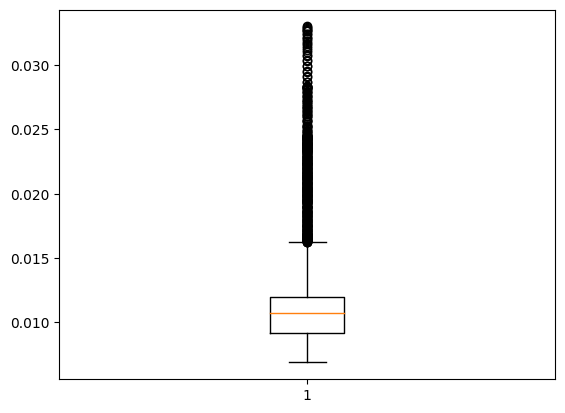

In [ ]:


plt.boxplot(validation_errors)
plt.show()

In [ ]:

anomalies_cnt = 0
with torch.no_grad():
    for batch in train_dataloader:
        batch = batch.float().to(device)
        outputs = model(batch)
        # loss = criterion(outputs, batch)
        loss = F.l1_loss(outputs, batch)

        if loss.item() > threshold:
            anomalies_cnt += 1
print(f"class D  acc: {anomalies_cnt/(len(train_d_seq))}")

class D  acc: 0.0


In [ ]:
test1_scaled = scaler.transform(test1)
test2_scaled = scaler.transform(test2)
test1_seq = TimeSeriesDataset(test1_scaled, sequence_length)
test2_seq = TimeSeriesDataset(test2_scaled, sequence_length)
test_d_seq = ConcatDataset([test1_seq, test2_seq])
test_dataloader = DataLoader(test_d_seq, batch_size=1, shuffle=True)


In [ ]:

anomalies_cnt = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.float().to(device)
        outputs = model(batch)
        # loss = criterion(outputs, batch)
        loss = F.l1_loss(outputs, batch)

        if loss.item() > threshold:
            anomalies_cnt += 1
print(f"class D  acc: {anomalies_cnt/(len(train_d_seq))}")

class D  acc: 0.2174164338695694


In [ ]:
def evaluate_per_class():
    driver_classes = selected_df['Class'].unique()
    for driver_cls in driver_classes:
        if driver_cls == 'D':
            continue

        test_data_one_driver_1 = alldata[(alldata['Class'] == driver_cls) & (alldata['PathOrder'] == 1)]
        test_data_one_driver_2 = alldata[(alldata['Class'] == driver_cls) & (alldata['PathOrder'] == 2)]

        test_data_one_driver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
        test_data_one_driver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)

        test_data_one_driver_1 = scaler.transform(test_data_one_driver_1)
        test_data_one_driver_2 = scaler.transform(test_data_one_driver_2)

        test_dataset_path2 = TimeSeriesDataset(test_data_one_driver_2, sequence_length)
        test_dataset_path1 = TimeSeriesDataset(test_data_one_driver_1, sequence_length)

        concatenated_data = ConcatDataset([test_dataset_path1, test_dataset_path2])
        test_dataloader = DataLoader(concatenated_data, batch_size=1, shuffle=True)

        anomalies_cnt = 0
        with torch.no_grad():
            for batch in test_dataloader:
                batch = batch.float().to(device)
                outputs = model(batch)
                # loss = criterion(outputs, batch)
                loss = F.l1_loss(outputs, batch)
                if loss.item() > threshold:
                    anomalies_cnt += 1

        print(f"class {driver_cls}  acc: {anomalies_cnt / (len(test_data_one_driver_1) + len(test_data_one_driver_2))}")


In [ ]:
evaluate_per_class()

class A  acc: 0.983150800336984
class B  acc: 0.9482190491134473
class C  acc: 0.697642915199133
class I  acc: 0.84148244473342
class J  acc: 0.9863419075802413
class H  acc: 0.883220651505839
class G  acc: 0.8482506102522376
class F  acc: 0.8005324031577015
class E  acc: 0.9855734551574897


In [ ]:
import pickle

# Save the model state dictionary
model_file_path = 'complex_time_series_autoencoder_rolling_features.pkl'
torch.save(model.state_dict(), model_file_path)

# Save the scaler
scaler_file_path = 'scaler.pkl'
with open(scaler_file_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)